# New York City Motor Vehicle Collisions
GitHub Repository: https://github.com/skhiearth/NYC-Motor-Vehicle-Collisions

Kaggle Kernel: https://www.kaggle.com/skhiearth/nyc-motor-vehicle-collisions (Uses a smaller dataset)

**Analysing and visualising Motor Vehicle Collisions in New York City with an objective to make the city roads safer using Data Science techniques. The [dataset](https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95) used is provided by NYC Open Data and contains details on the crash event. The Motor Vehicle Collisions data tables contain information from all police reported motor vehicle collisions in NYC.**

In [1]:
# Import the required packages
import os
import calendar
import datetime
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.dates as mdates
import seaborn as sns
from pywaffle import Waffle
import geopandas as gpd

### Importing data

Download the static file from [here](https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD). Dynamic data can be fetched using the Socrata Open Data API (SODA). 
Note that SODA limits a single API call to 1000 rows, so please use the offset parameter to make multiple API calls
to fetch all rows.
The exact static file version used here has been uploaded to Google Drive, and made public. You may access this version from [here](https://drive.google.com/open?id=1Wv9yya3u3HjnP2XZbxouFUnyLD4plU4Y).

In [2]:
# Importing static dataset from .csv file
raw_data = pd.read_csv('datasets/Motor_Vehicle_Collisions_-_Crashes.csv')

print(raw_data.shape)
raw_data.head(3)

(904482, 29)


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,04/02/2016,22:23,BRONX,10456.0,NaN,NaN,NaN,WESTCHESTER AVENUE,UNION AVENUE,NaN,...,NaN,NaN,NaN,NaN,3411047.0,PASSENGER VEHICLE,NaN,NaN,NaN,NaN
1,01/06/2020,12:50,NaN,NaN,NaN,NaN,NaN,PRINCE STREET,NaN,NaN,...,Failure to Yield Right-of-Way,NaN,NaN,NaN,4269674.0,Sedan,Tractor Truck Diesel,NaN,NaN,NaN
2,01/06/2020,13:16,MANHATTAN,10018.0,NaN,NaN,NaN,40 STREET,12 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4269909.0,Sedan,Bus,NaN,NaN,NaN


### Column(s) Descriptions:

1. `CRASH DATE`: The date of the collision.
2. `CRASH TIME`: The time of the collision.
3. `BOROUGH`: The city borough in which the collision occured.
4. `LATITUDE`, `LONGITUDE` and `LOCATION`: Geographical coordinates of the collision.
5. `ON STREET NAME`: Street on which the collision occurred.
6. `CROSS STREET NAME`: Nearest cross street to the collision.
7. `OFF STREET NAME`: Street address (if known).
8. `NUMBER OF PERSONS INJURED`, `NUMBER OF PERSONS KILLED`, `NUMBER OF PEDESTRIANS INJURED`, `NUMBER OF PEDESTRIANS KILLED`, `NUMBER OF CYCLIST INJURED`, `NUMBER OF CYCLIST KILLED`, `NUMBER OF MOTORIST INJURED` and `NUMBER OF MOTORIST KILLED`: Details about the number of people injured or killed in the accident.
9. `CONTRIBUTING FACTOR VEHICLE 1-5`: Factors contributing to the collision for designated vehicle.
10. `COLLISION_ID`: Unique record code generated by the system.
11. `VEHICLE TYPE CODE 1-5`: Type of vehicle based on the selected vehicle category.

### Data Pre-processing and Cleaning

In [3]:
# Removing columns that have more than a third values as NaN
mask = raw_data.isna().sum() / len(raw_data) < 0.34
raw_data = raw_data.loc[:, mask]

# Removing columns that don't have a large contributing factor to EDA and Predictions
cols_to_drop = ['ZIP CODE', 'LOCATION', 
                'CONTRIBUTING FACTOR VEHICLE 2', 'VEHICLE TYPE CODE 2']
raw_data.drop(cols_to_drop, axis = 1, inplace = True)

In [4]:
# Concatenating date and time columns
raw_data['CRASH_DATE_TIME'] = raw_data['CRASH DATE'] + ' ' + raw_data['CRASH TIME']

# Drop redundant date and time columns
cols_to_drop = ['CRASH DATE', 'CRASH TIME']
raw_data.drop(cols_to_drop, axis = 1, inplace = True)

In [5]:
# Convert Crash Date and time to datetime format
raw_data['CRASH_DATE_TIME']= pd.to_datetime(raw_data['CRASH_DATE_TIME'], 
                                            dayfirst=True, errors='coerce')

# Dropping rows with problematics dates
idx = raw_data[raw_data['CRASH_DATE_TIME'].isnull()].index
raw_data.drop(idx, axis = 0, inplace = True)

print(raw_data.shape)
raw_data.head(3)

(904477, 16)


,BOROUGH,LATITUDE,LONGITUDE,ON STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,COLLISION_ID,VEHICLE TYPE CODE 1,CRASH_DATE_TIME
0,BRONX,NaN,NaN,WESTCHESTER AVENUE,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Driver Inattention/Distraction,3411047.0,PASSENGER VEHICLE,2016-02-04 22:23:00
1,NaN,NaN,NaN,PRINCE STREET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Lane Marking Improper/Inadequate,4269674.0,Sedan,2020-06-01 12:50:00
2,MANHATTAN,NaN,NaN,40 STREET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Following Too Closely,4269909.0,Sedan,2020-06-01 13:16:00


### Borough-wise Analysis

In [6]:
borough_wise = raw_data.groupby(['BOROUGH']).size().reset_index(name='NoOfAccidents')
borough_wise.head()

,BOROUGH,NoOfAccidents
0,BRONX,89247
1,BROOKLYN,189648
2,MANHATTAN,133376
3,QUEENS,164321
4,STATEN ISLAND,22822


The [GIS data](https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm) with the Boundaries of Boroughs for New York City is obtained from NYC Open Data. The data is provided by the Department of City Planning (DCP).

In [7]:
# Import the ShapeFile for Borough Boundaries
fp = 'datasets/Borough Boundaries/geo_export_87071461-9196-46f3-8d1b-52fed88fb835.shp'
borough_geo = gpd.read_file(fp)
borough_geo['boro_name'] = borough_geo['boro_name'].str.upper() 

# Merging ShapeFile with data
borough_wise = borough_geo.set_index('boro_name').join(borough_wise.set_index('BOROUGH'))

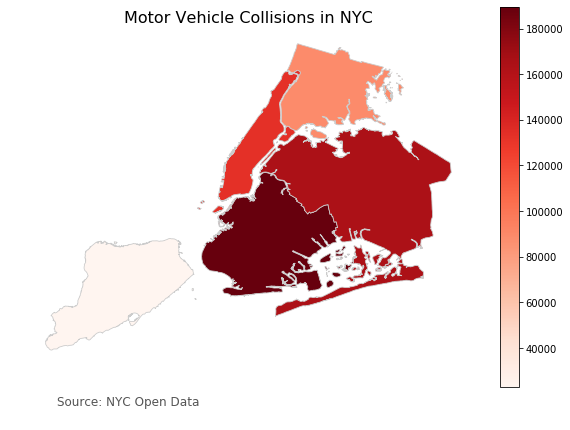

In [8]:
# Create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 7))

# Drawing the Map
borough_wise.plot(column = 'NoOfAccidents', cmap = 'Reds', linewidth = 0.8, 
                      ax = ax, edgecolor = '0.8')

# Map customizations
ax.axis('off')
ax.set_title('Motor Vehicle Collisions in NYC', size = 16)
ax.annotate('Source: NYC Open Data', xy = (0.1, .08),  
            xycoords = 'figure fraction', horizontalalignment = 'left', verticalalignment = 'top', 
            fontsize = 12, color = '#555555')

# Adding a color bar legend to the map
sm = plt.cm.ScalarMappable(cmap = 'Reds', 
                           norm = plt.Normalize(vmin = 22822, vmax = 189648))
cbar = fig.colorbar(sm)

# Export map
fig.savefig('plots/borough_wise_accidents.png', dpi=300)

**Analysis: Brooklyn and Queens have reported a very high number of accidents. On the other hand, Staten Island reported the least number of accidents in New York City boroughs.**

In [9]:
injuries_and_fatalities = raw_data.groupby(['BOROUGH'])\
['NUMBER OF PERSONS KILLED', 'NUMBER OF PERSONS INJURED'].agg('sum').reset_index()

injuries_and_fatalities['Total Accidents'] = raw_data.groupby(['BOROUGH']).size().\
reset_index(name='NoOfAccidents').NoOfAccidents

# Injuries and Fatalities as Percentages
injuries_and_fatalities['Injury%'] = round((injuries_and_fatalities['NUMBER OF PERSONS INJURED']\
/ injuries_and_fatalities['Total Accidents'] * 100), 1)
injuries_and_fatalities['Fatality%'] = round((injuries_and_fatalities['NUMBER OF PERSONS KILLED']\
/ injuries_and_fatalities['Total Accidents'] * 100), 3)

injuries_and_fatalities.head()

,BOROUGH,NUMBER OF PERSONS KILLED,NUMBER OF PERSONS INJURED,Total Accidents,Injury%,Fatality%
0,BRONX,75.0,24820.0,89247,27.8,0.084
1,BROOKLYN,206.0,52861.0,189648,27.9,0.109
2,MANHATTAN,101.0,23188.0,133376,17.4,0.076
3,QUEENS,181.0,43231.0,164321,26.3,0.110
4,STATEN ISLAND,35.0,5833.0,22822,25.6,0.153


In [10]:
# Dropping redudant column and merging with ShapeFile
injuries_and_fatalities.drop('Total Accidents', axis = 1, inplace = True)
injuries_and_fatalities = borough_geo.set_index('boro_name').join(injuries_and_fatalities.set_index('BOROUGH'))

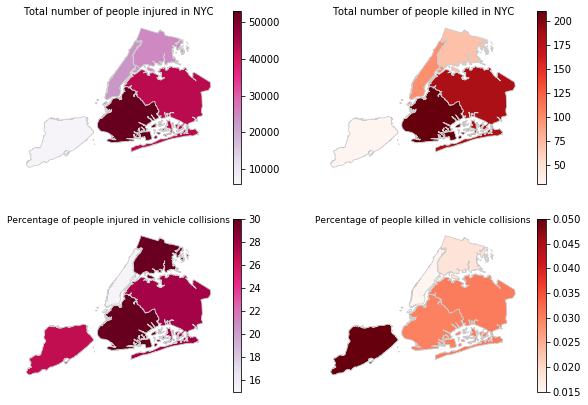

In [11]:
# Create figure and axes for Matplotlib
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10, 7))

# Drawing the maps
injuries_and_fatalities.plot(column = 'NUMBER OF PERSONS INJURED', cmap = 'PuRd', linewidth = 0.8, 
                      ax = ax1, edgecolor = '0.8')
injuries_and_fatalities.plot(column = 'NUMBER OF PERSONS KILLED', cmap = 'Reds', linewidth = 0.8, 
                      ax = ax2, edgecolor = '0.8')
injuries_and_fatalities.plot(column = 'Injury%', cmap = 'PuRd', linewidth = 0.8, 
                      ax = ax3, edgecolor = '0.8')
injuries_and_fatalities.plot(column = 'Fatality%', cmap = 'Reds', linewidth = 0.8, 
                      ax = ax4, edgecolor = '0.8')

# Map customizations
ax1.axis('off'); ax2.axis('off'); ax3.axis('off'); ax4.axis('off')
ax1.set_title('Total number of people injured in NYC', size = 10)
ax2.set_title('Total number of people killed in NYC', size = 10)
ax3.set_title('Percentage of people injured in vehicle collisions', size = 9)
ax4.set_title('Percentage of people killed in vehicle collisions', size = 9)

# Adding color bar legends to the maps
sm = plt.cm.ScalarMappable(cmap = 'PuRd', norm = plt.Normalize(vmin = 5800, vmax = 53000))
cbar = fig.colorbar(sm, ax = ax1)

sm = plt.cm.ScalarMappable(cmap = 'Reds', norm = plt.Normalize(vmin = 30, vmax = 210))
cbar = fig.colorbar(sm, ax = ax2)

sm = plt.cm.ScalarMappable(cmap = 'PuRd', norm = plt.Normalize(vmin = 15, vmax = 30))
cbar = fig.colorbar(sm, ax = ax3)

sm = plt.cm.ScalarMappable(cmap = 'Reds', norm = plt.Normalize(vmin = 0.05, vmax = 0.015))
cbar = fig.colorbar(sm, ax = ax4)

# Export map
fig.savefig('plots/borough_wise_injury_percentage.png', dpi=500)

**Analysis: Brooklyn and Bronx have reported a very high percentage of accidents that result in injury. Queens and Staten Island also have a very high percentage, third and fourth to the first two borough by only a couple of percentages. On the other hand, Manhattan reported the least number of accidents in New York City boroughs.**

### Contributing Factor Analysis

In the dataset, the column `CONTRIBUTING FACTOR VEHICLE 1` gives the factor contributing to the collision for designated vehicle. 

In [12]:
# Calculate the number of people killed, injured and total accidents for each contributing factor
factor_wise = raw_data.groupby(['CONTRIBUTING FACTOR VEHICLE 1'])\
['NUMBER OF PERSONS KILLED', 'NUMBER OF PERSONS INJURED'].agg('sum').reset_index()

factor_wise['Total Accidents'] = raw_data.groupby(['CONTRIBUTING FACTOR VEHICLE 1']).size().\
reset_index(name='NoOfAccidents').NoOfAccidents

# 'Unspecified' factor is the most common factor in motor vehicle collissions reported by the NYPD, 
# but since these don't give us any concrete analysis, we won't consider this, and hence we drop it.
factor_wise = factor_wise.sort_values('Total Accidents', ascending = False).head(10).iloc[1:]

# Injuries and Fatalities as Percentages
factor_wise['Injury%'] = round((factor_wise['NUMBER OF PERSONS INJURED']/factor_wise['Total Accidents'] * 100), 1)
factor_wise['Fatality%'] = round((factor_wise['NUMBER OF PERSONS KILLED']/factor_wise['Total Accidents'] * 100), 3)

# Drop last two
factor_wise = factor_wise[:-1]
factor_wise.head(3)

,CONTRIBUTING FACTOR VEHICLE 1,NUMBER OF PERSONS KILLED,NUMBER OF PERSONS INJURED,Total Accidents,Injury%,Fatality%
11,Driver Inattention/Distraction,139.0,55953.0,203436,27.5,0.068
21,Following Too Closely,7.0,21137.0,66711,31.7,0.010
18,Failure to Yield Right-of-Way,101.0,25941.0,59170,43.8,0.171


#### Most common reasons for accidents:

In [13]:
factor_accidents = factor_wise.sort_values('Total Accidents', ascending = False).head(10)
factor_accidents.head(3)

,CONTRIBUTING FACTOR VEHICLE 1,NUMBER OF PERSONS KILLED,NUMBER OF PERSONS INJURED,Total Accidents,Injury%,Fatality%
11,Driver Inattention/Distraction,139.0,55953.0,203436,27.5,0.068
21,Following Too Closely,7.0,21137.0,66711,31.7,0.010
18,Failure to Yield Right-of-Way,101.0,25941.0,59170,43.8,0.171


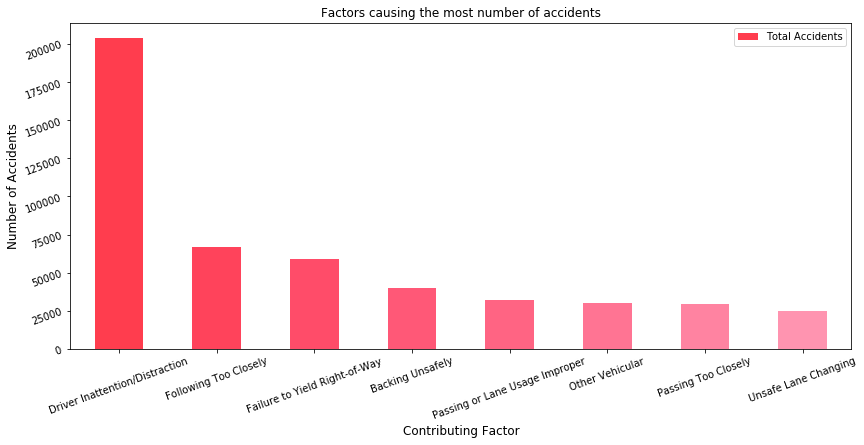

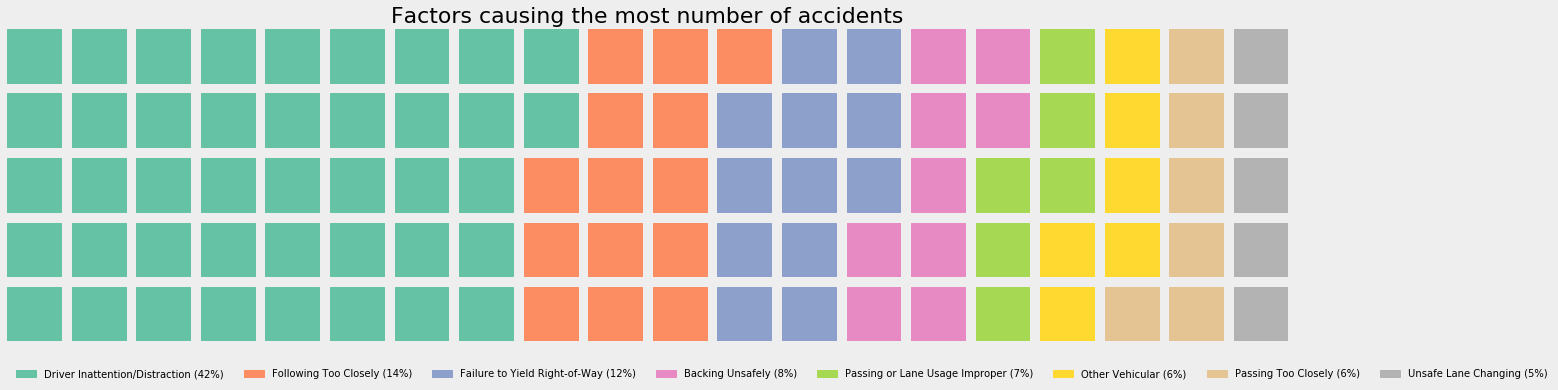

In [14]:
# Create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(14, 6))

# Defining color map
color = np.flip(cm.Reds(np.linspace(.2,.6, 10)))

# Creating the plot
factor_accidents.plot(x = 'CONTRIBUTING FACTOR VEHICLE 1', 
                      y = 'Total Accidents', kind = 'bar', 
                      color = color, stacked = True, ax = ax)

# Customizing the Visulation
ax.set_title('Factors causing the most number of accidents', size = 12)
ax.set_xlabel('Contributing Factor', size = 12)
ax.set_ylabel('Number of Accidents', size = 12)
ax.tick_params(labelrotation = 20)

# Exporting the visualisation
fig.savefig('plots/factor_accidents.png', dpi=500)

waf_df = factor_accidents[['CONTRIBUTING FACTOR VEHICLE 1', 'Total Accidents']].\
set_index('CONTRIBUTING FACTOR VEHICLE 1')


# Waffle Chart 
waf = plt.figure(
    FigureClass = Waffle, 
    rows = 5, 
    values = ((waf_df['Total Accidents'] / 485767) * 100) ,
    title={'label': 'Factors causing the most number of accidents', 
           'loc': 'center', 'size': 22},
    labels=["{0} ({1}%)".format(k, round((v / 485767) * 100), 2) for k, v in waf_df['Total Accidents'].items()],
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.15), 'ncol': len(waf_df), 'framealpha': 0},
    starting_location='NW',
    figsize=(22, 8)
)

waf.gca().set_facecolor('#EEEEEE')
waf.set_facecolor('#EEEEEE')

# Exporting the visualisation
waf.savefig('plots/factor_accidents_waffle.png', dpi=500)

**Analysis: Driver Distraction is by far the most common factor leading to accidents on the roads of New York City. This is a strong argument in favor of the promotion of self-driving cars to make our roads safer.**

#### Contributing Factors with highest injury and fatality rate:

In [15]:
factor_inj_rate = factor_wise.sort_values('Injury%', ascending = False).head(10)
factor_fat_rate = factor_wise.sort_values('Fatality%', ascending = False).head(10)

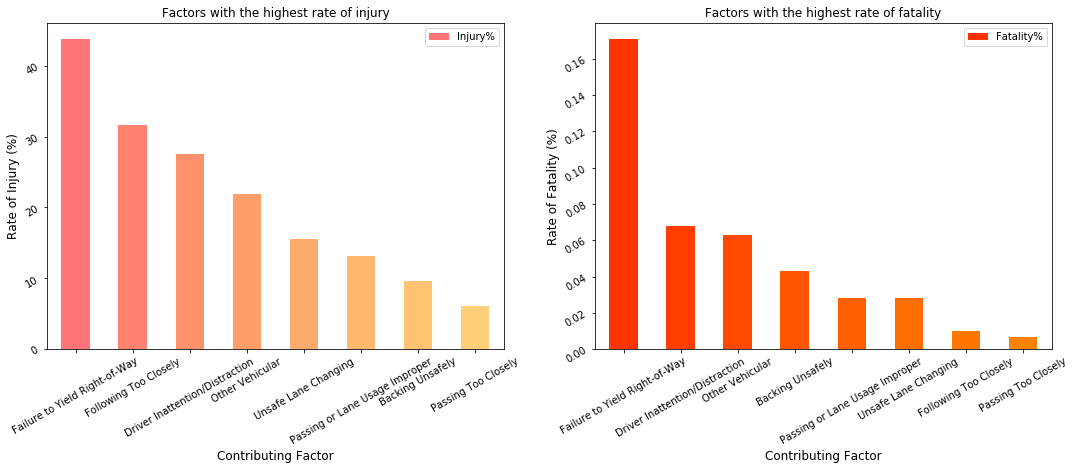

In [16]:
# Create figure and axes for Matplotlib
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Defining color map
color = np.flip(cm.plasma(np.linspace(.2,.6, 10)))
color2 = cm.autumn(np.linspace(.2,.6, 10))

# Creating the plots
factor_inj_rate.plot(x = 'CONTRIBUTING FACTOR VEHICLE 1', 
                      y = 'Injury%', kind = 'bar', 
                      color = color, stacked = True, ax = ax1)

factor_fat_rate.plot(x = 'CONTRIBUTING FACTOR VEHICLE 1', 
                      y = 'Fatality%', kind = 'bar', 
                      color = color2, stacked = True, ax = ax2)

# Customizing the Visulation
ax1.set_title('Factors with the highest rate of injury', size = 12)
ax1.set_xlabel('Contributing Factor', size = 12)
ax1.set_ylabel('Rate of Injury (%)', size = 12)
ax1.tick_params(labelrotation = 30)

ax2.set_title('Factors with the highest rate of fatality', size = 12)
ax2.set_xlabel('Contributing Factor', size = 12)
ax2.set_ylabel('Rate of Fatality (%)', size = 12)
ax2.tick_params(labelrotation = 30)

# Exporting the visualisation
fig.savefig('plots/factor_inj_fat_rate.png', dpi=500)

**Analysis: `Failure to Yield Right-of-Way` is by far the most common factor for fatality, with more than 16% of all accidents resulting in deaths. `Driver Inattention/Distraction` is a distant second with around 6%. In terms of injuries, the rate is much higher, which `Failure to Yield Right-of-Way` again being the factor with the highest rate of over 45%. `Following Too Closely`, `Driver Inattention/Distraction` and `Other Vehicular` also have very high rate of injuries (around 20-30%).**

### Vehicle Type Analysis

In the dataset, the column `VEHICLE TYPE CODE 1` gives the type of the vehicle which was involved in the motor collision.

In [17]:
# Calculate the number of people killed, injured and total accidents for each vehicle type
vehicle_wise = raw_data.groupby(['VEHICLE TYPE CODE 1'])\
['NUMBER OF PERSONS KILLED', 'NUMBER OF PERSONS INJURED'].agg('sum').reset_index()

vehicle_wise['Total Accidents'] = raw_data.groupby(['VEHICLE TYPE CODE 1']).size().\
reset_index(name='NoOfAccidents').NoOfAccidents

vehicle_wise = vehicle_wise.sort_values('Total Accidents', ascending = False)
# Injuries and Fatalities as Percentages
vehicle_wise['Injury%'] = round((vehicle_wise['NUMBER OF PERSONS INJURED']/vehicle_wise['Total Accidents'] * 100), 1)
vehicle_wise['Fatality%'] = round((vehicle_wise['NUMBER OF PERSONS KILLED']/vehicle_wise['Total Accidents'] * 100), 3)

# Filtering vehicles involved in atleast 100 accidents
mask = vehicle_wise['Total Accidents'] > 100
vehicle_wise = vehicle_wise[mask]

vehicle_wise.head(3)

,VEHICLE TYPE CODE 1,NUMBER OF PERSONS KILLED,NUMBER OF PERSONS INJURED,Total Accidents,Injury%,Fatality%
337,PASSENGER VEHICLE,202.0,70655.0,278202,25.4,0.073
427,Sedan,121.0,48214.0,167897,28.7,0.072
408,SPORT UTILITY / STATION WAGON,140.0,40556.0,163790,24.8,0.085


In [18]:
vehicle_accidents = vehicle_wise.sort_values('Total Accidents', ascending = False).head(10)
vehicle_accidents.head(5)

,VEHICLE TYPE CODE 1,NUMBER OF PERSONS KILLED,NUMBER OF PERSONS INJURED,Total Accidents,Injury%,Fatality%
337,PASSENGER VEHICLE,202.0,70655.0,278202,25.4,0.073
427,Sedan,121.0,48214.0,167897,28.7,0.072
408,SPORT UTILITY / STATION WAGON,140.0,40556.0,163790,24.8,0.085
438,Station Wagon/Sport Utility Vehicle,153.0,37667.0,136480,27.6,0.112
446,TAXI,22.0,6133.0,23607,26.0,0.093


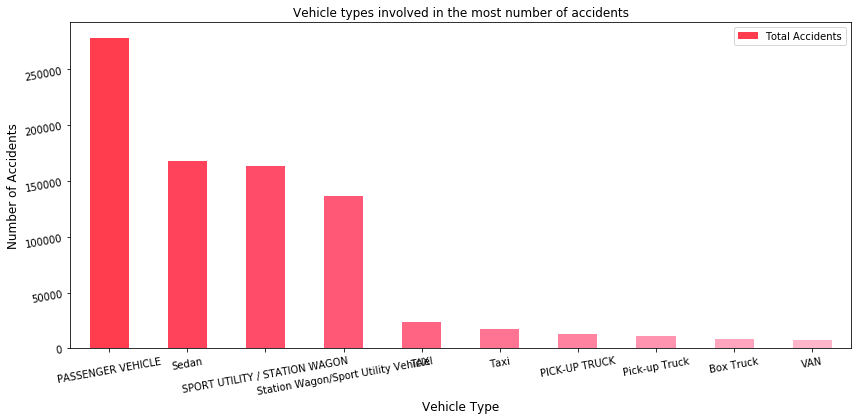

In [19]:
# Create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(14, 6))

# Defining color map
color = np.flip(cm.Reds(np.linspace(.2,.6, 10)))

# Creating the plot
vehicle_accidents.plot(x = 'VEHICLE TYPE CODE 1', 
                      y = 'Total Accidents', kind = 'bar', 
                      color = color, stacked = True, ax = ax)

# Customizing the Visulation
ax.set_title('Vehicle types involved in the most number of accidents', size = 12)
ax.set_xlabel('Vehicle Type', size = 12)
ax.set_ylabel('Number of Accidents', size = 12)
ax.tick_params(labelrotation = 10)

# Exporting the visualisation
fig.savefig('plots/vehicle_type_accidents.png', dpi=500)

In [20]:
vehicle_inj_rate = vehicle_wise.sort_values('Injury%', ascending = False).head(10)
vehicle_fat_rate = vehicle_wise.sort_values('Fatality%', ascending = False).head(10)

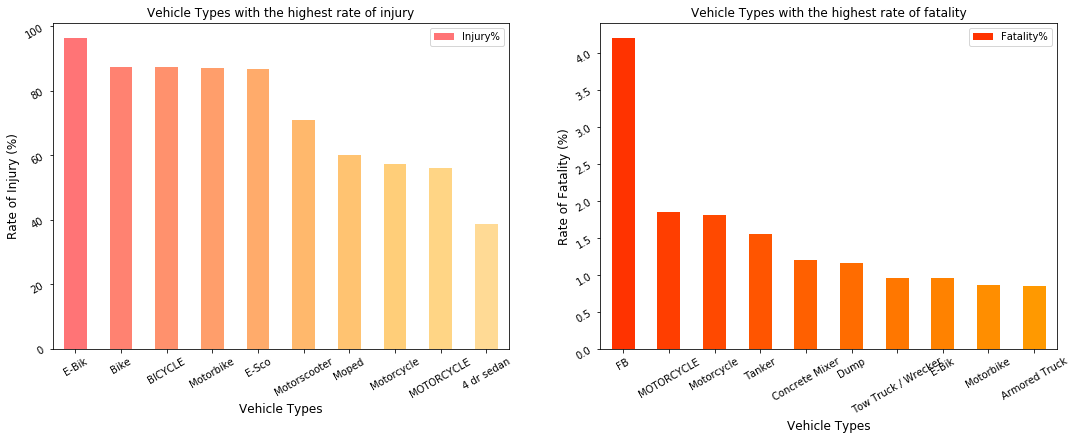

In [21]:
# Create figure and axes for Matplotlib
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Defining color map
color = np.flip(cm.plasma(np.linspace(.2,.6, 10)))
color2 = cm.autumn(np.linspace(.2,.6, 10))

# Creating the plots
vehicle_inj_rate.plot(x = 'VEHICLE TYPE CODE 1', 
                      y = 'Injury%', kind = 'bar', 
                      color = color, stacked = True, ax = ax1)

vehicle_fat_rate.plot(x = 'VEHICLE TYPE CODE 1', 
                      y = 'Fatality%', kind = 'bar', 
                      color = color2, stacked = True, ax = ax2)

# Customizing the Visulation
ax1.set_title('Vehicle Types with the highest rate of injury', size = 12)
ax1.set_xlabel('Vehicle Types', size = 12)
ax1.set_ylabel('Rate of Injury (%)', size = 12)
ax1.tick_params(labelrotation = 30)

ax2.set_title('Vehicle Types with the highest rate of fatality', size = 12)
ax2.set_xlabel('Vehicle Types', size = 12)
ax2.set_ylabel('Rate of Fatality (%)', size = 12)
ax2.tick_params(labelrotation = 30)

# Exporting the visualisation
fig.savefig('plots/vehicle_inj_fat_rate.png', dpi=500)

**Analysis: Passenger Vehicles are the vehicle types involved in the most number of accident, followed by Sedands and SUVs/Station Wagons. `E-Bik`, `Bike`, `Bicycle`, `Motorbike`, `E-Sco`, `Motorscooter`, `Moped` and `Motercycle` types have an extreme rate of injury (>50%). Hence, it can be concluded that two wheelers are prone to injuries. `FB`, `Motorcycle`, `Tanker`, `Concerete Mixer`, `Dump`, `Tow Trucks`, `E-Bik`, `Motorbike` and `Armored Truck` have the highest rate of fatality. Hence, it can be concluded that vehicles of the extreme weights are more deadly.**

### Do Date and Time play any role?

In [22]:
# Keeping only the date from the Datetime column
date_only = raw_data.copy() 
date_only['Date'] = date_only['CRASH_DATE_TIME'].dt.date

# Calculate the number of people killed, injured and total accidents for each date
date_wise = date_only.groupby(['Date'])\
['NUMBER OF PERSONS KILLED', 'NUMBER OF PERSONS INJURED'].agg('sum').reset_index()

date_wise['Total Accidents'] = date_only.groupby(['Date']).size().\
reset_index(name='NoOfAccidents').NoOfAccidents

# Injuries and Fatalities as Percentages
date_wise['Injury%'] = round((date_wise['NUMBER OF PERSONS INJURED']/date_wise['Total Accidents'] * 100), 1)
date_wise['Fatality%'] = round((date_wise['NUMBER OF PERSONS KILLED']/date_wise['Total Accidents'] * 100), 3)

date_wise = date_wise.sort_values('Total Accidents', ascending = False)

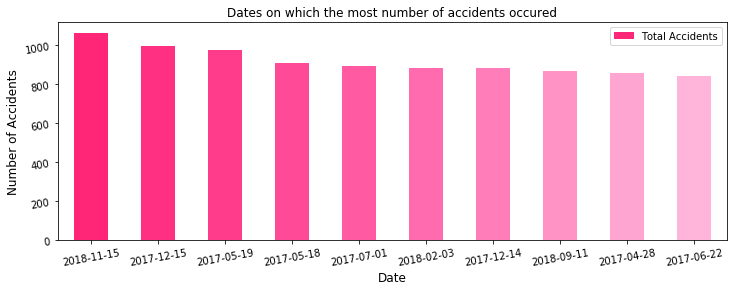

In [23]:
date_accidents = date_wise.sort_values('Total Accidents', ascending = False).head(10)

# Create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(12, 4))

# Defining color map
color = np.flip(cm.Oranges(np.linspace(.2,.6, 10)))

# Creating the plot
date_accidents.plot(x = 'Date', 
                      y = 'Total Accidents', kind = 'bar', 
                      color = color, stacked = True, ax = ax)

# Customizing the Visulation
ax.set_title('Dates on which the most number of accidents occured', size = 12)
ax.set_xlabel('Date', size = 12)
ax.set_ylabel('Number of Accidents', size = 12)
ax.tick_params(labelrotation = 10)

# Exporting the visualisation
fig.savefig('plots/date_accidents.png', dpi=500)

#### Does the year and month play a role?

In [24]:
# Monthly Data
month_only = raw_data.copy() 
month_only['Date'] = month_only['CRASH_DATE_TIME']
mask = month_only['Date'] > '2014-12-31' 
month_only = month_only[mask]

mask2 = month_only['Date'] < '2019-12-31' 
month_only = month_only[mask2]

# Set dates to end of the month
month_only['Year'] = month_only['Date'].map(
    lambda x: datetime.datetime(
        x.year,
        x.month,
        max(calendar.monthcalendar(x.year, x.month)[-1][:5])
    )
)

# Calculate the number of people killed, injured and total accidents for each month
month_wise = month_only.groupby(['Year'])\
['NUMBER OF PERSONS KILLED', 'NUMBER OF PERSONS INJURED'].agg('sum').reset_index()

month_wise['Total Accidents'] = month_only.groupby(['Year']).size().\
reset_index(name='NoOfAccidents').NoOfAccidents

# Injuries and Fatalities as Percentages
month_wise['Injury%'] = round((month_wise['NUMBER OF PERSONS INJURED']/month_wise['Total Accidents'] * 100), 1)
month_wise['Fatality%'] = round((month_wise['NUMBER OF PERSONS KILLED']/month_wise['Total Accidents'] * 100), 3)

month_wise = month_wise.sort_values('Total Accidents', ascending = False)

month_wise.head()

,Year,NUMBER OF PERSONS KILLED,NUMBER OF PERSONS INJURED,Total Accidents,Injury%,Fatality%
29,2017-06-30,21.0,5459.0,20848,26.2,0.101
40,2018-05-31,19.0,5492.0,20626,26.6,0.092
45,2018-10-31,25.0,5676.0,20569,27.6,0.122
33,2017-10-31,34.0,5475.0,20449,26.8,0.166
30,2017-07-31,34.0,5474.0,20435,26.8,0.166


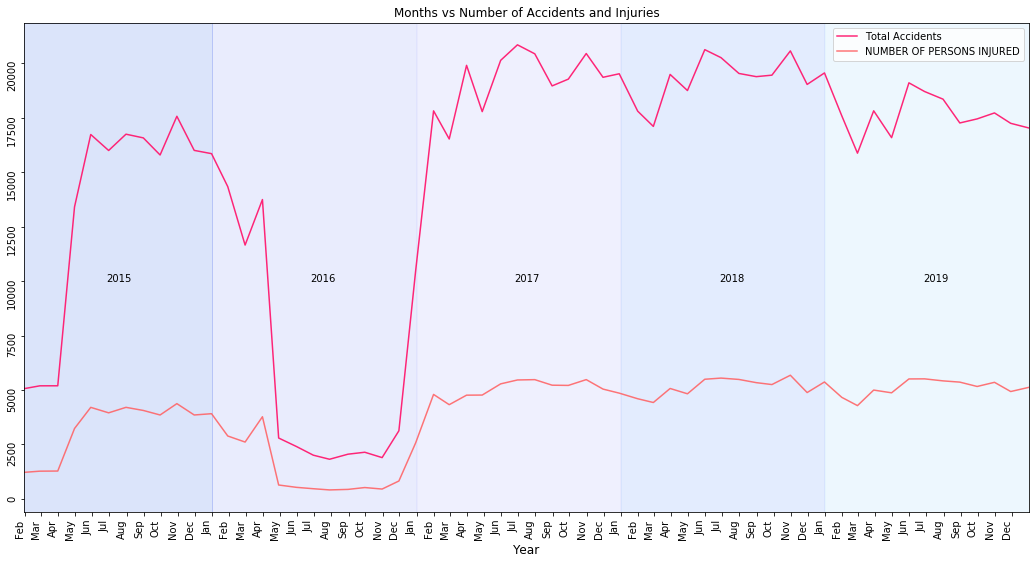

In [25]:
# Create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(18, 10))

# Defining color map
color = np.flip(cm.Oranges(np.linspace(.2,.6, 10)))
color2 = np.flip(cm.plasma(np.linspace(.2,.6, 10)))

# Creating the plot
month_wise.plot(x = 'Year', y = 'Total Accidents', kind = 'line', 
                color = color, stacked = True, ax = ax)
month_wise.plot(x = 'Year', y = 'NUMBER OF PERSONS INJURED', kind = 'line', 
                color = color2, stacked = True, ax = ax)

# Customizing the Visulation
ax.set_title('Months vs Number of Accidents and Injuries', size = 12)
ax.set_xlabel('Year', size = 12)
ax.tick_params(labelrotation = 90)

# Set the locator
locator = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b')

x_axis = plt.gca().xaxis
x_axis.set_major_locator(locator)

# Specify formatter
x_axis.set_major_formatter(fmt)

plt.axvspan('2015-01-30', '2015-12-31', alpha = 0.14, color = 'xkcd:blue')
plt.text('2015-06-25', 10000, '2015')

plt.axvspan('2016-01-01', '2016-12-31', alpha = 0.14, color = 'xkcd:cornflower')
plt.text('2016-06-25', 10000, '2016')

plt.axvspan('2017-01-01', '2017-12-31', alpha = 0.14, color = 'xkcd:periwinkle blue')
plt.text('2017-06-25', 10000, '2017')

plt.axvspan('2018-01-01', '2018-12-31', alpha = 0.14, color = 'xkcd:lightish blue')
plt.text('2018-06-25', 10000, '2018')

plt.axvspan('2019-01-01', '2019-12-31', alpha = 0.14, color = 'xkcd:sky')
plt.text('2019-06-25', 10000, '2019')

# Exporting the visualisation
fig.savefig('plots/month_accidents.png', dpi=500)

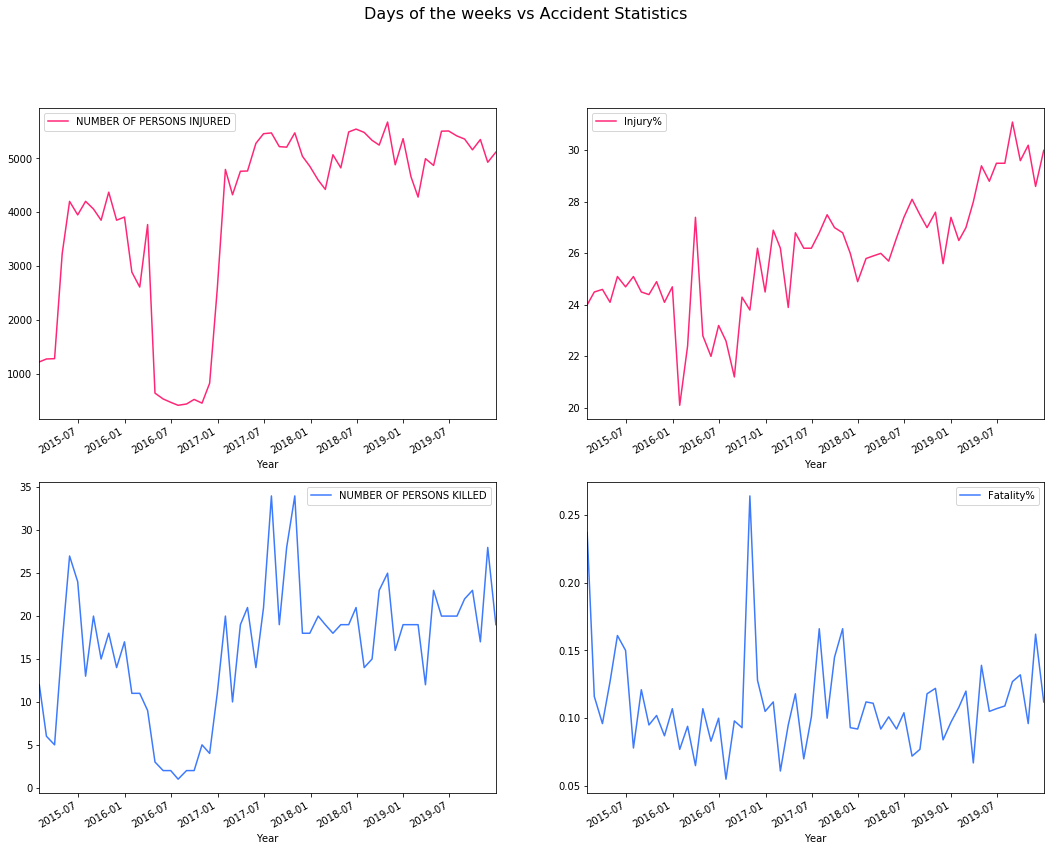

In [26]:
# Create figure and axes for Matplotlib
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize=(18, 14))

# Defining color map
color = np.flip(cm.Oranges(np.linspace(.2,.6, 10)))
color2 = np.flip(cm.plasma(np.linspace(.2,.6, 10)))

# Creating the plot
fig.suptitle('Days of the weeks vs Accident Statistics', fontsize=16)

month_wise.plot(x = 'Year', y = 'NUMBER OF PERSONS INJURED', kind = 'line', 
                color = color, stacked = True, ax = ax1)
month_wise.plot(x = 'Year', y = 'Injury%', kind = 'line', 
                color = color, stacked = True, ax = ax2)
month_wise.plot(x = 'Year', y = 'NUMBER OF PERSONS KILLED', kind = 'line', 
                color = 'xkcd:lightish blue', stacked = True, ax = ax3)
month_wise.plot(x = 'Year', y = 'Fatality%', kind = 'line', 
                color = 'xkcd:lightish blue', stacked = True, ax = ax4)

# Exporting the visualisation
fig.savefig('plots/month_accidents_stats.png', dpi=500)

#### Day of the week vs Accidents

In [27]:
# Monthly Data
week_only = raw_data.copy() 
week_only['Weekday'] = week_only['CRASH_DATE_TIME'].dt.day_name()

# Calculate the number of people killed, injured and total accidents for each month
week_wise = week_only.groupby(['Weekday'])\
['NUMBER OF PERSONS KILLED', 'NUMBER OF PERSONS INJURED'].agg('sum').reset_index()

week_wise['Total Accidents'] = week_only.groupby(['Weekday']).size().\
reset_index(name='NoOfAccidents').NoOfAccidents

# Injuries and Fatalities as Percentages
week_wise['Injury%'] = round((week_wise['NUMBER OF PERSONS INJURED']/week_wise['Total Accidents'] * 100), 1)
week_wise['Fatality%'] = round((week_wise['NUMBER OF PERSONS KILLED']/week_wise['Total Accidents'] * 100), 3)

# Sort
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
week_wise['Week_day'] = pd.Categorical(week_wise['Weekday'], 
                                   categories=cats, 
                                   ordered=True)

week_wise = week_wise.sort_values('Week_day')

week_wise.head()

,Weekday,NUMBER OF PERSONS KILLED,NUMBER OF PERSONS INJURED,Total Accidents,Injury%,Fatality%,Week_day
1,Monday,157.0,34145.0,131107,26.0,0.120,Monday
5,Tuesday,144.0,33908.0,130175,26.0,0.111,Tuesday
6,Wednesday,130.0,33868.0,132321,25.6,0.098,Wednesday
4,Thursday,130.0,35272.0,136357,25.9,0.095,Thursday
0,Friday,136.0,35591.0,136542,26.1,0.100,Friday


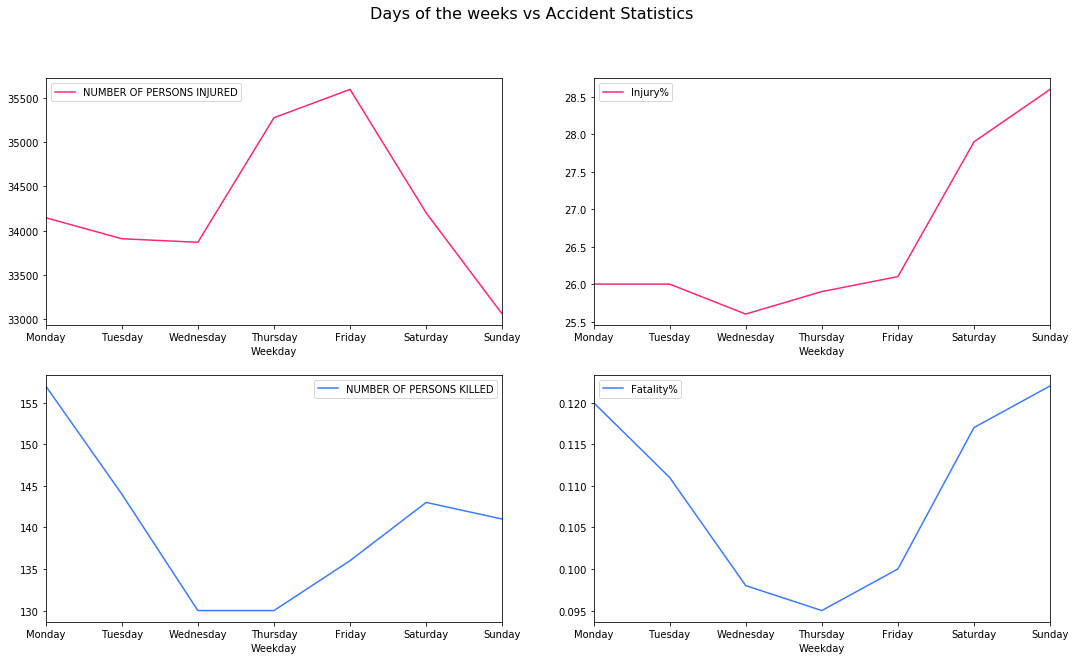

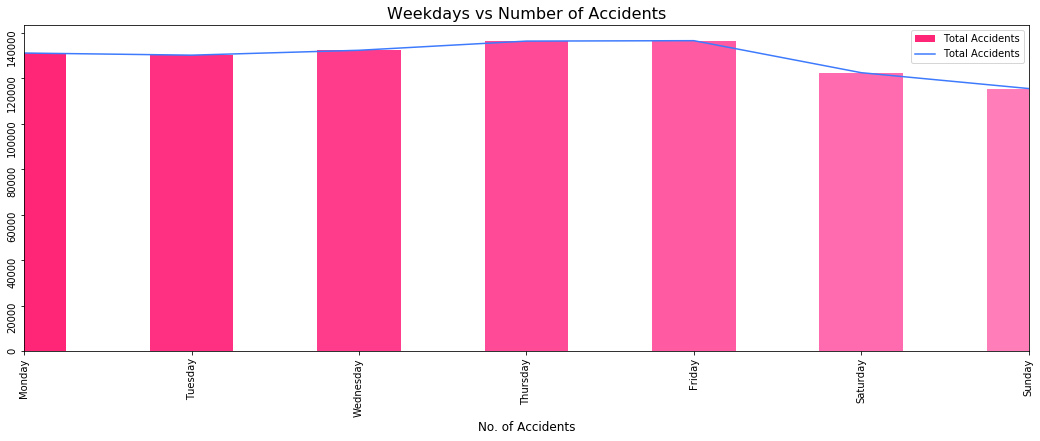

In [28]:
# Create figure and axes for Matplotlib
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize=(18, 10))

# Create figure and axes for Matplotlib
fig2, ax = plt.subplots(1, figsize=(18, 6))

# Defining color map
color = np.flip(cm.Oranges(np.linspace(.2,.6, 10)))
color2 = np.flip(cm.plasma(np.linspace(.2,.6, 10)))

# Creating the plot
week_wise.plot(x = 'Weekday', y = 'Total Accidents', kind = 'bar', 
                color = color, stacked = True, ax = ax)
week_wise.plot(x = 'Weekday', y = 'Total Accidents', kind = 'line', 
                color = 'xkcd:lightish blue', stacked = True, ax = ax)

fig.suptitle('Days of the weeks vs Accident Statistics', fontsize=16)

week_wise.plot(x = 'Weekday', y = 'NUMBER OF PERSONS INJURED', kind = 'line', 
                color = color, stacked = True, ax = ax1)
week_wise.plot(x = 'Weekday', y = 'Injury%', kind = 'line', 
                color = color, stacked = True, ax = ax2)
week_wise.plot(x = 'Weekday', y = 'NUMBER OF PERSONS KILLED', kind = 'line', 
                color = 'xkcd:lightish blue', stacked = True, ax = ax3)
week_wise.plot(x = 'Weekday', y = 'Fatality%', kind = 'line', 
                color = 'xkcd:lightish blue', stacked = True, ax = ax4)

# Customizing the Visulation
ax.set_title('Weekdays vs Number of Accidents', size = 16)
ax.set_xlabel('Weekday', size = 12)
ax.set_xlabel('No. of Accidents', size = 12)
ax.tick_params(labelrotation = 90)

# Exporting the visualisation
fig.savefig('plots/weekday_accidents_stats.png', dpi=500)
fig2.savefig('plots/weekday_accidents.png', dpi=500)

#### Does the time play a role?

In [29]:
# Timely Data
time_only = raw_data.copy() 
time_only['Time'] = time_only['CRASH_DATE_TIME'].dt.hour

# Calculate the number of people killed, injured and total accidents for each time period
time_wise = time_only.groupby(['Time'])\
['NUMBER OF PERSONS KILLED', 'NUMBER OF PERSONS INJURED'].agg('sum').reset_index()

time_wise['Total Accidents'] = time_only.groupby(['Time']).size().\
reset_index(name='NoOfAccidents').NoOfAccidents

# Injuries and Fatalities as Percentages
time_wise['Injury%'] = round((time_wise['NUMBER OF PERSONS INJURED']/time_wise['Total Accidents'] * 100), 1)
time_wise['Fatality%'] = round((time_wise['NUMBER OF PERSONS KILLED']/time_wise['Total Accidents'] * 100), 3)

time_wise = time_wise.sort_values('Time', ascending = True)

time_wise.head()

,Time,NUMBER OF PERSONS KILLED,NUMBER OF PERSONS INJURED,Total Accidents,Injury%,Fatality%
0,0,46.0,9017.0,29385,30.7,0.157
1,1,42.0,4526.0,14074,32.2,0.298
2,2,28.0,3515.0,10503,33.5,0.267
3,3,42.0,3383.0,9294,36.4,0.452
4,4,57.0,3946.0,10753,36.7,0.530


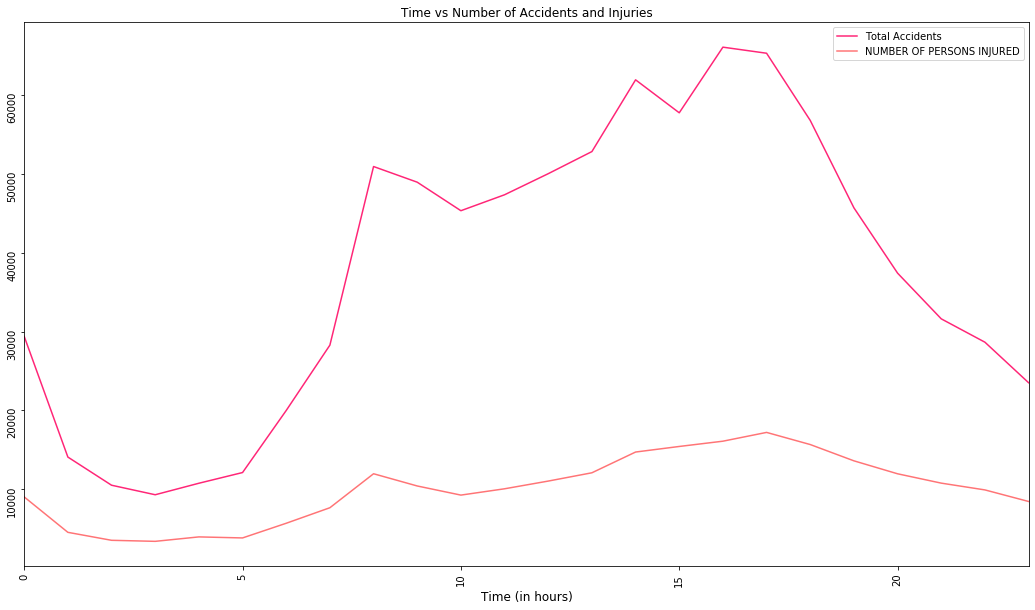

In [30]:
# Create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(18, 10))

# Defining color map
color = np.flip(cm.Oranges(np.linspace(.2,.6, 10)))
color2 = np.flip(cm.plasma(np.linspace(.2,.6, 10)))

# Creating the plot
time_wise.plot(x = 'Time', y = 'Total Accidents', kind = 'line', 
                color = color, stacked = True, ax = ax)
time_wise.plot(x = 'Time', y = 'NUMBER OF PERSONS INJURED', kind = 'line', 
                color = color2, stacked = True, ax = ax)

# Customizing the Visulation
ax.set_title('Time vs Number of Accidents and Injuries', size = 12)
ax.set_xlabel('Time (in hours)', size = 12)
ax.tick_params(labelrotation = 90)

# Exporting the visualisation
fig.savefig('plots/time_accidents.png', dpi=500)

In [31]:
# Average number of accidents by date
date_wise['Total Accidents'].mean()

536.1452282157676

It can be seen that are several dates on which an unusually high number of accidents occured. Since weather conditions can play a major role in motor accidents, we match the weather conditions on the days when more than 536 accidents (more than the average) were reported, and try to find a correlation.

In [32]:
# Filtering dates with more than 536 accidents
mask = date_wise['Total Accidents'] > 536
vehicle_accidents_500 = date_wise[mask]
print("Average no. of people injured on dates when more than 536 accidents happened: " + \
      str(vehicle_accidents_500['NUMBER OF PERSONS INJURED'].mean()))
print("Total people killed on dates when more than 536 accidents happened: " + \
      str(vehicle_accidents_500['NUMBER OF PERSONS KILLED'].sum()))

Average no. of people injured on dates when more than 536 accidents happened: 168.9315188762072
Total people killed on dates when more than 536 accidents happened: 764.0


As it can be seen, an average of 170 people were injured and a total of 764 people were killed on these particular days. So, any correlation between these days and other factors can help the authorities to improve road safety.

#### Weather Matching: ([Powered by Dark Sky](https://darksky.net/poweredby/))

In [33]:
# Dark Sky Secret Key
secret_key = '5fb8fb4569a3cb7c29fe665e7c8dad66'

In [34]:
NYC_LAT = '40.730610'
NYC_LONG = '-73.935242'

In [35]:
# Limiting to first 100 rows to prevent API overuse using Development Phase
vehicle_accidents_500_date = vehicle_accidents_500.copy()['Date'].head(100) 

frame = {'Date': vehicle_accidents_500_date} 
vehicle_accidents_500_date_df = pd.DataFrame(frame) 

In [36]:
casts = []

for date in vehicle_accidents_500_date_df['Date'].values.tolist():
    dt = str(date)
    date_time = dt + "T12:00:00"
    link = "https://api.darksky.net/forecast/{}/{},{},{}".format(secret_key, NYC_LAT, NYC_LONG, date_time)
    
    # Sending GET request and saving the response as a response object
    r = requests.get(url = link)
    
    # Unpacking data in JSON Format
    data = r.json() 
    to_cast = data['currently']['summary']
    
    casts.append(to_cast)

# Adding the result to the dataframe
vehicle_accidents_500_date_df['Summary'] = casts

In [37]:
# Joining the dataframes
vehicle_accidents_500_date_df = date_wise.set_index('Date').\
join(vehicle_accidents_500_date_df.set_index('Date'))

In [38]:
to_plot = vehicle_accidents_500_date_df.head(10)

# Calculate the number of people killed, injured and total accidents for each contributing factor
to_plot_grouped = to_plot.groupby(['Summary'])\
['NUMBER OF PERSONS KILLED', 'NUMBER OF PERSONS INJURED'].agg('sum').reset_index()

to_plot_grouped['Total Accidents'] = to_plot.groupby(['Summary']).size().\
reset_index(name='NoOfAccidents').NoOfAccidents

# Injuries and Fatalities as Percentages
to_plot_grouped['Injury%'] = round((to_plot_grouped['NUMBER OF PERSONS INJURED']/to_plot_grouped['Total Accidents'] * 100), 1)
to_plot_grouped['Fatality%'] = round((to_plot_grouped['NUMBER OF PERSONS KILLED']/to_plot_grouped['Total Accidents'] * 100), 3)

to_plot_grouped = to_plot_grouped.sort_values('Total Accidents', ascending = False)

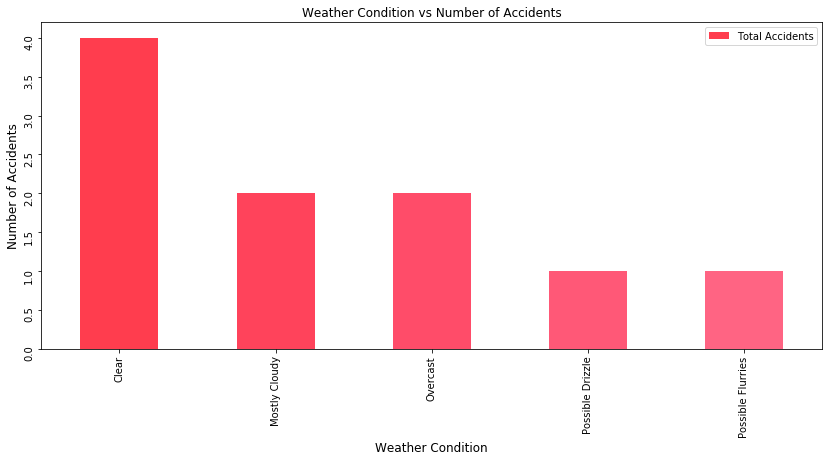

In [39]:
# Create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(14, 6))

# Defining color map
color = np.flip(cm.Reds(np.linspace(.2,.6, 10)))

# Creating the plot
to_plot_grouped.plot(x = 'Summary', y = 'Total Accidents', 
             kind = 'bar', color = color, 
             stacked = True, ax = ax)

# Customizing the Visulation
ax.set_title('Weather Condition vs Number of Accidents', size = 12)
ax.set_xlabel('Weather Condition', size = 12)
ax.set_ylabel('Number of Accidents', size = 12)
ax.tick_params(labelrotation = 90)

# Exporting the visualisation
fig.savefig('plots/weather_summary_accidents.png', dpi=500)

In [40]:
weather_inj_rate = to_plot_grouped.sort_values('Injury%', ascending = False).head(10)
weather_inj = to_plot_grouped.sort_values('NUMBER OF PERSONS INJURED', ascending = False).head(10)
weather_fat_rate = to_plot_grouped.sort_values('Fatality%', ascending = False).head(10)
weather_fat = to_plot_grouped.sort_values('NUMBER OF PERSONS KILLED', ascending = False).head(10)

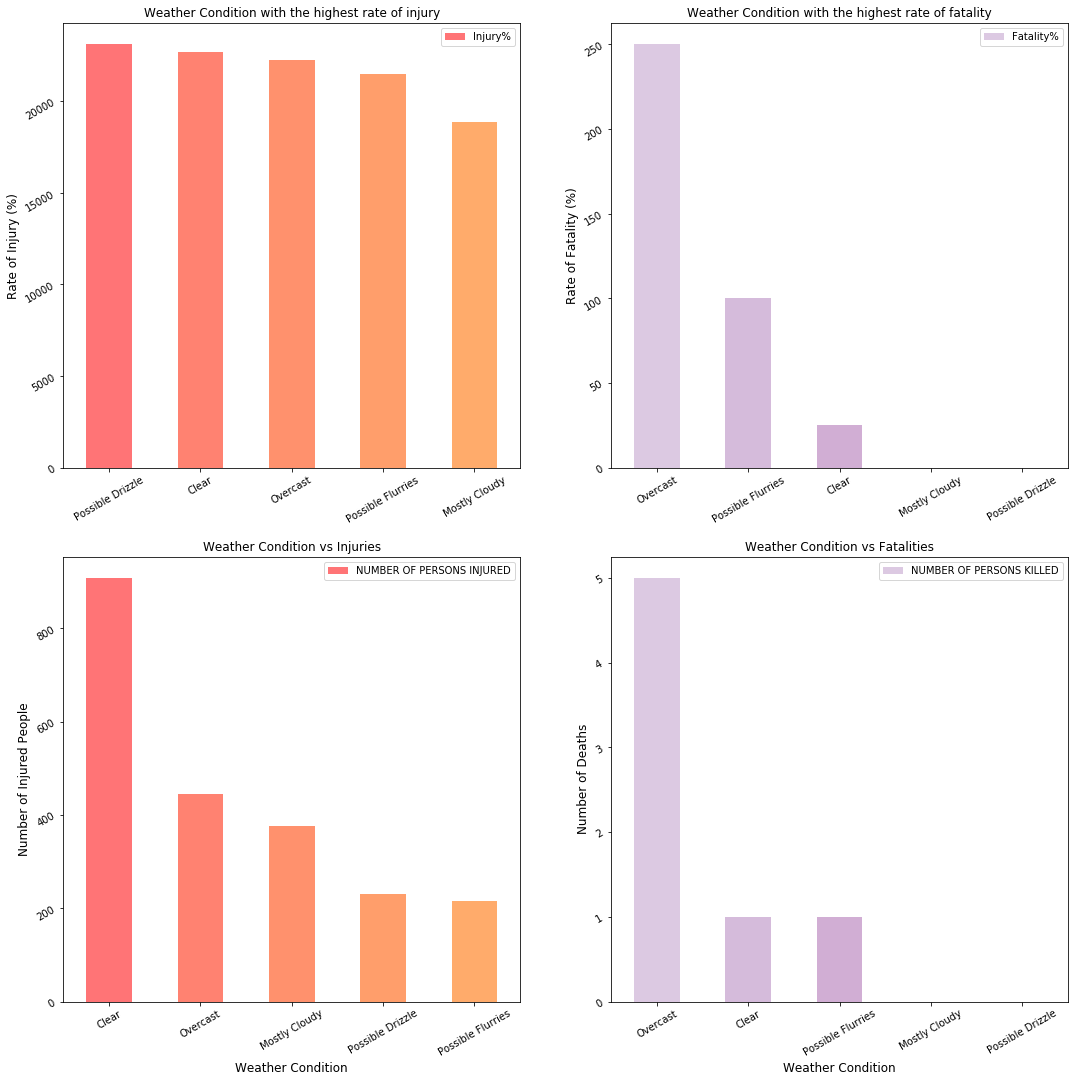

In [41]:
# Create figure and axes for Matplotlib
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(18, 18))

# Defining color map
color = np.flip(cm.plasma(np.linspace(.2,.6, 10)))
color2 = cm.PuRd(np.linspace(.2,.6, 10))

# Creating the plots
weather_inj_rate.plot(x = 'Summary', 
                      y = 'Injury%', kind = 'bar', 
                      color = color, stacked = True, ax = ax1)

weather_inj.plot(x = 'Summary', y = 'NUMBER OF PERSONS INJURED', kind = 'bar', 
                 color = color, stacked = True, ax = ax3)

weather_fat_rate.plot(x = 'Summary', 
                      y = 'Fatality%', kind = 'bar', 
                      color = color2, stacked = True, ax = ax2)

weather_fat.plot(x = 'Summary', y = 'NUMBER OF PERSONS KILLED', kind = 'bar', 
                 color = color2, stacked = True, ax = ax4)

# Customizing the Visulation
ax1.set_title('Weather Condition with the highest rate of injury', size = 12)
ax1.set_ylabel('Rate of Injury (%)', size = 12)
ax1.set_xlabel(' ', size = 12)
ax1.tick_params(labelrotation = 30)

ax2.set_title('Weather Condition with the highest rate of fatality', size = 12)
ax2.set_ylabel('Rate of Fatality (%)', size = 12)
ax2.set_xlabel(' ', size = 12)
ax2.tick_params(labelrotation = 30)

ax3.set_title('Weather Condition vs Injuries', size = 12)
ax3.set_xlabel('Weather Condition', size = 12)
ax3.set_ylabel('Number of Injured People', size = 12)
ax3.tick_params(labelrotation = 30)

ax4.set_title('Weather Condition vs Fatalities', size = 12)
ax4.set_xlabel('Weather Condition', size = 12)
ax4.set_ylabel('Number of Deaths', size = 12)
ax4.tick_params(labelrotation = 30)

# Exporting the visualisation
fig.savefig('plots/weather_inj_fat_rate.png', dpi=500)